### Import Necessary Libraries

In [ ]:
%pip install kaggle
%pip install pandas
%pip install matplotlib
%pip install sklearn
%pip install seaborn
%pip install scikit-image

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import tensorflow as tf
from sklearn.model_selection
from tensorflow.keras import layers , models
from tensorflow.keras.layers import *

### Download Fer-2013 dataset in Kaggle

In [7]:
""" 1. Install the Kaggle API 
    2. Setup Kaggle API credentials
        - Go to your Kaggle account settings: Kaggle Account Settings.
        - Scroll down to the API section and click on Create New API Token. This will download a file named kaggle.json.
        - Place the kaggle.json file in the directory ~/.kaggle/ (Linux/Mac) or %USERPROFILE%\.kaggle\ (Windows).
        - If it's not recognized then start %USERPROFILE%\.kaggle
"""

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files("msambare/fer2013", path="data", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


In [8]:
def Classes_Count(path, name):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    Classes_Dict = {cls: 0 for cls in classes}  # initialize with zeroes

    for data_class in classes:
        full_path = os.path.join(path, data_class)  
        if os.path.exists(full_path):
            Classes_Dict[data_class] = len(os.listdir(full_path))

    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

In [10]:
fer_train = "data/train"
fer_test = "data/test"

In [13]:
train_count = Classes_Count(fer_train, 'train').transpose().sort_values(by="train", ascending=False)
test_count = Classes_Count(fer_test, 'test').transpose().sort_values(by="test", ascending=False)

# Combine both
combined_counts = pd.concat([train_count, test_count], axis=1)

# Reorder rows according to your class order
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
combined_counts = combined_counts.reindex(classes)

# Display
print(combined_counts)

          train  test
angry      3995   958
disgust     436   111
fear       4097  1024
happy      7215  1774
neutral    4965  1233
sad        4830  1247
surprise   3171   831


Visualizing Images by choose random 5 images to check the images and classes

In [16]:
# Visualize images
import random 
import cv2

def show_images_from_dataset(dataset_dir, num_images=5):
    emotions = os.listdir(dataset_dir)
    for emotion in emotions:
      if emotion[0] != '.': #skip hidden files
          emotion_dir = os.path.join(dataset_dir, emotion)
          img_names = os.listdir(emotion_dir)
          random.shuffle(img_names)

          plt.figure(figsize=(10, 5))
          plt.suptitle(f'Emotion: {emotion}', fontsize=16)

          for i in range(num_images):
              img_path = os.path.join(emotion_dir, img_names[i])
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              if img is not None:
                  plt.subplot(1, num_images, i + 1)
                  plt.imshow(img, cmap='gray')

          plt.show()

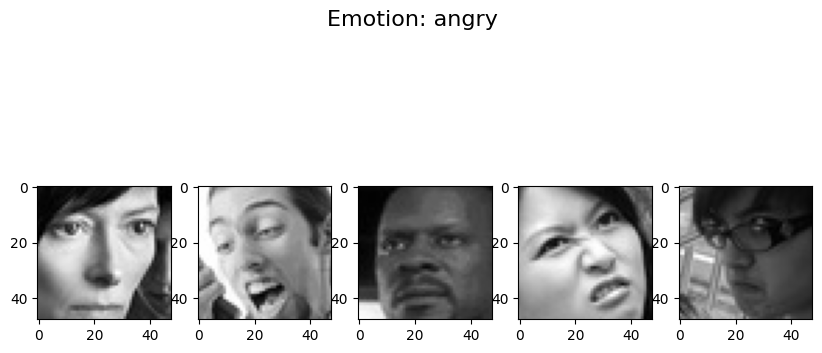

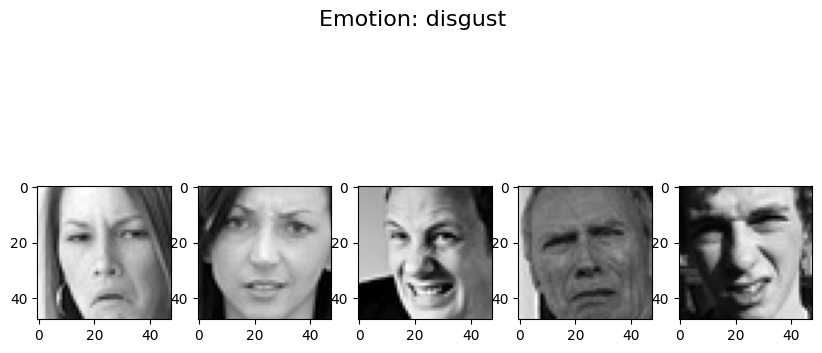

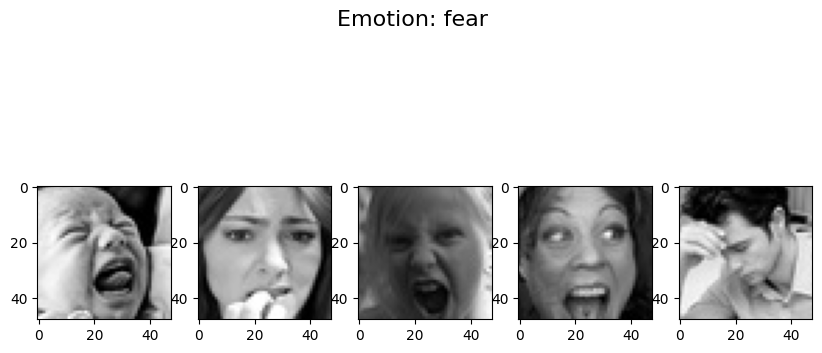

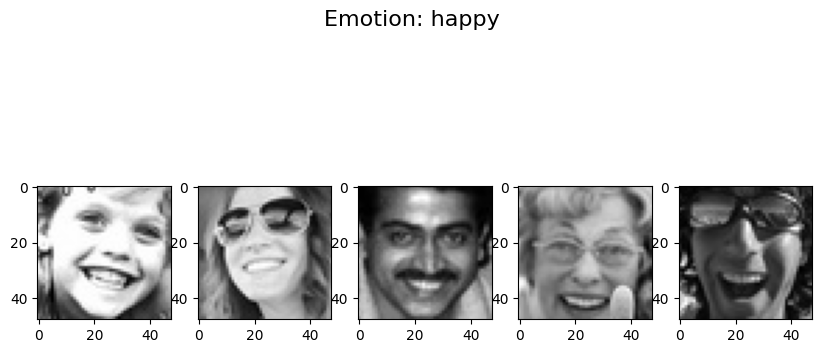

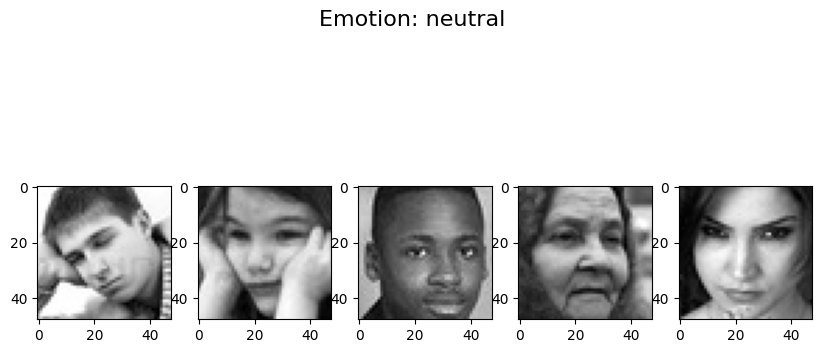

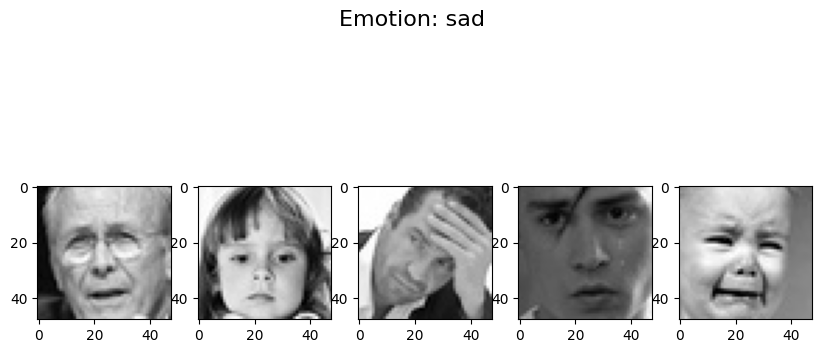

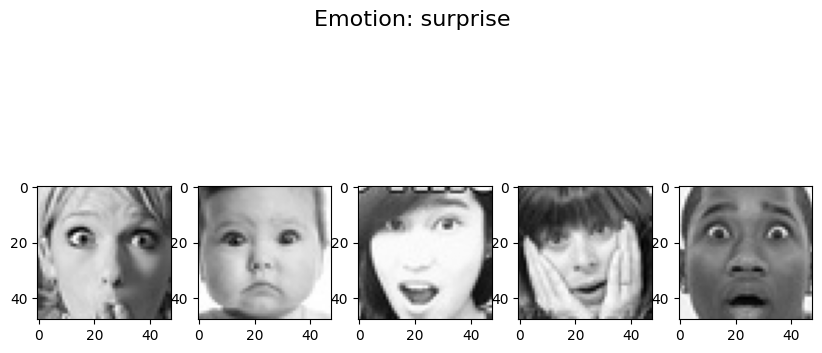

In [17]:
show_images_from_dataset(fer_train, num_images=5)

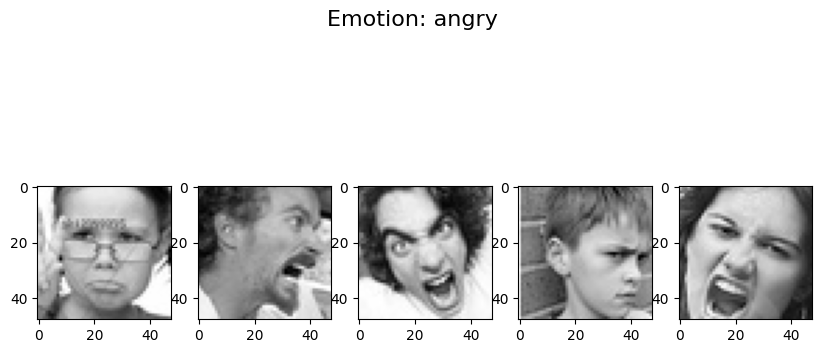

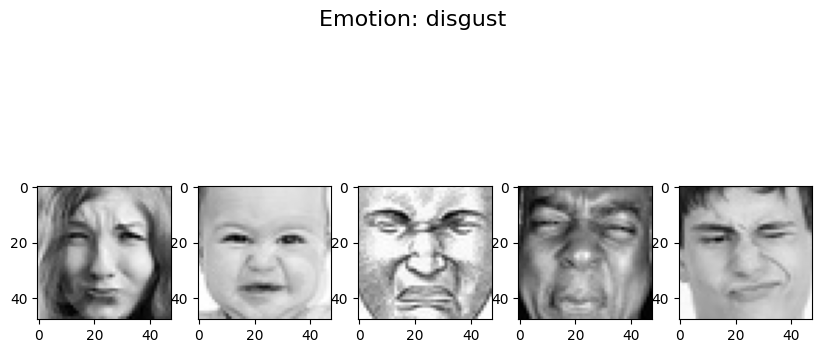

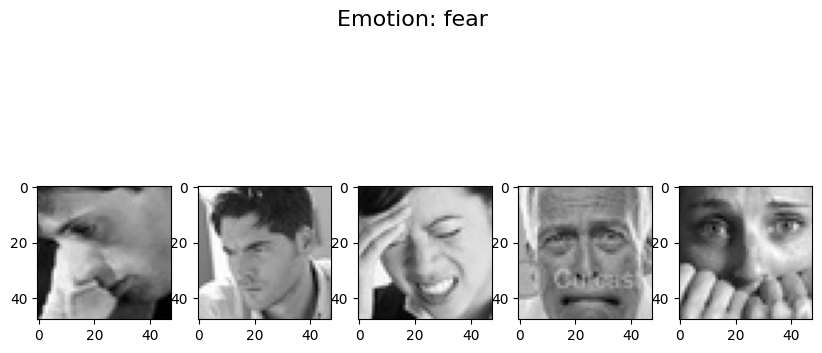

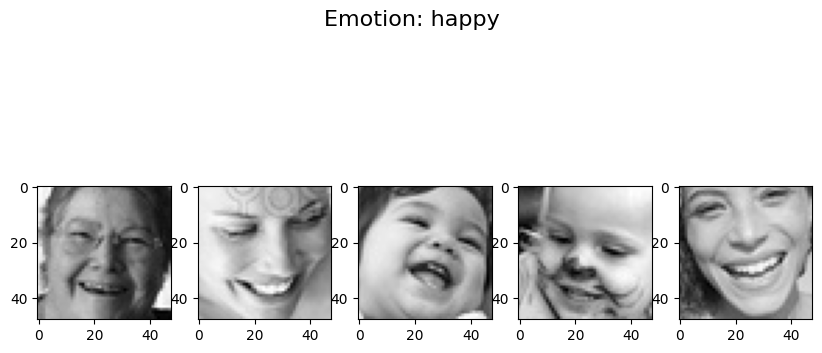

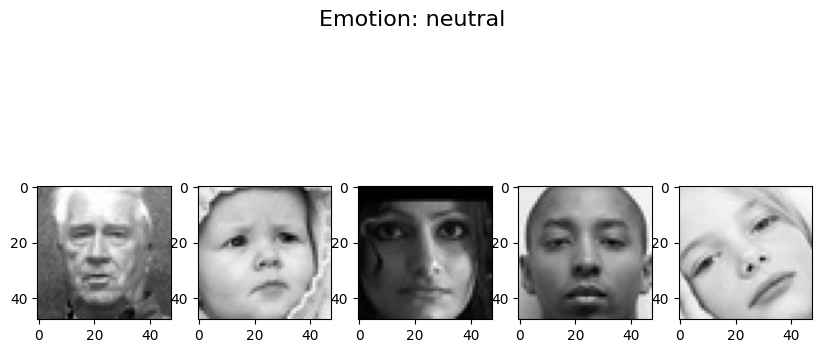

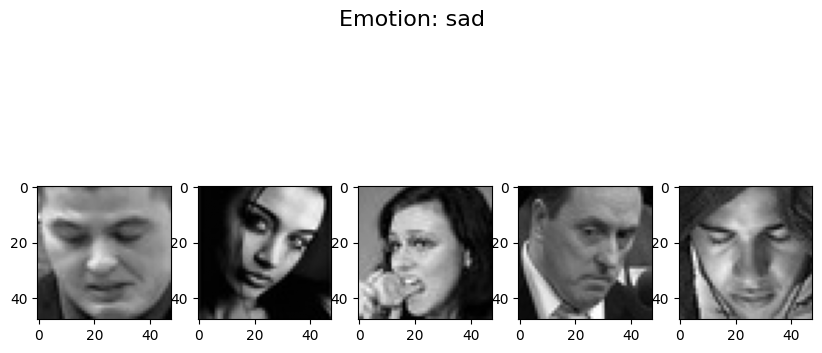

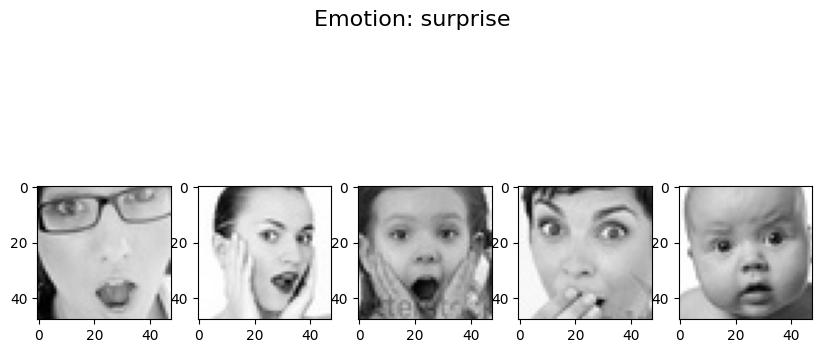

In [18]:
show_images_from_dataset(fer_test, num_images=5)

### Change image dataset to CSV for training

- Simplifies loading: CSV format is easy to read and load using libraries like pandas, allowing you to quickly access all images and labels without scanning folders.
- Eases preprocessing: You can manipulate, normalize, reshape, and split data using powerful DataFrame operations — much more efficient than working with images directly from disk.
- Enables reproducibility: Having a CSV ensures that the same dataset and label mapping can be shared or reused consistently across different runs, models, or collaborators.
- Improves performance: Loading preprocessed data from CSV is usually faster than reading and decoding thousands of image files during training.
- Standardizes format: CSV is a universal format that integrates well with most machine learning pipelines, libraries, and storage systems.
- Reduces errors: You eliminate risks related to missing files, inconsistent folder names, or corrupt images because everything gets processed up front.
- Convenient for debugging: It’s easy to open and inspect a CSV manually or visualize samples without needing special tools.



In [63]:
import os
import numpy as np
from PIL import Image
import pandas as pd

# Define paths
fer_train = "data/train"
fer_test = "data/test"
data_folder = "data"
train_csv_path = os.path.join(data_folder, "fer2013_train.csv")
test_csv_path = os.path.join(data_folder, "fer2013_test.csv")

# Ensure the data folder exists
os.makedirs(data_folder, exist_ok=True)

# Emotion categories (must match subfolder names)
emotion_categories = ['angry', 'disgust', 'Fear', 'happy', 'neutral', 'sad', 'surprise']

def process_dataset(image_folder_path, output_csv_path):
    image_data = []
    labels = []

    for label, emotion in enumerate(emotion_categories):
        emotion_folder = os.path.join(image_folder_path, emotion)

        if not os.path.exists(emotion_folder):
            print(f"Skipping missing folder: {emotion_folder}")
            continue

        for image_name in os.listdir(emotion_folder):
            image_path = os.path.join(emotion_folder, image_name)

            try:
                image = Image.open(image_path).convert('L')
                image = image.resize((48, 48))
                flattened = np.array(image).flatten()

                image_data.append(flattened)
                labels.append(label)
            except Exception as e:
                print(f"Failed to process {image_path}: {e}")

    df = pd.DataFrame(image_data)
    df['emotion'] = labels
    df.to_csv(output_csv_path, index=False)
    print(f"Saved CSV: {output_csv_path}")

# Process both sets
process_dataset(fer_train, train_csv_path)
process_dataset(fer_test, test_csv_path)

Saved CSV: data\fer2013_train.csv
Saved CSV: data\fer2013_test.csv


In [69]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load and process training data
train_data = pd.read_csv('data/fer2013_train.csv')
X_train = train_data.drop(columns=['emotion']).values / 255.0
X_train = X_train.reshape(-1, 48, 48, 1)
y_train = to_categorical(LabelEncoder().fit_transform(train_data['emotion']), num_classes=7)

# Load and process test data
test_data = pd.read_csv('data/fer2013_test.csv')
X_test = test_data.drop(columns=['emotion']).values / 255.0
X_test = X_test.reshape(-1, 48, 48, 1)
y_test = to_categorical(LabelEncoder().fit_transform(test_data['emotion']), num_classes=7)

In [72]:
from sklearn.model_selection import train_test_split

# After processing your X_train and y_train:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

### Custom CNN to train model

- **Sequential Model**: Uses a linear stack of layers for simplicity and readability.
  
- **First Convolutional Block**:
  - `Conv2D(64, (3, 3))`: Extracts low-level features like edges from grayscale 48×48 images.
  - `MaxPooling2D(2, 2)`: Downsamples the feature maps to reduce spatial dimensions.

- **Second Convolutional Block**:
  - `Conv2D(128, (3, 3))`: Captures more complex patterns.
  - `MaxPooling2D(2, 2)`: Again reduces dimensions and computation.

- **Third Convolutional Block**:
  - `Conv2D(256, (3, 3))`: Learns deeper visual abstractions.
  - `MaxPooling2D(2, 2)`: Shrinks the final feature maps before flattening.

- **Flatten Layer**:
  - Converts 3D feature maps into a 1D vector for the dense layers.

- **Fully Connected Layers**:
  - `Dense(512)`: A strong hidden layer with ReLU for non-linear learning.
  - `Dropout(0.5)`: Randomly drops 50% of the neurons during training to reduce overfitting.

- **Output Layer**:
  - `Dense(7, activation='softmax')`: Outputs class probabilities for 7 emotion categories.


In [70]:
# Build the CNN model
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting
model.add(layers.Dense(7, activation='softmax'))  # 7 classes for emotions

d:\MoodBuddy\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

### 13. Train the Model 

- Training for 60 epochs using X_train, y_train
- Batch size: 64
- Validation split: 20%
- Model saved as fer_emotion_model.h5

In [75]:
# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_split=0.2)

# Save the model
model.save('fer_emotion_model.h5')

Epoch 1/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.2408 - loss: 1.8225 - precision_4: 0.3355 - recall_4: 0.0011 - val_accuracy: 0.3010 - val_loss: 1.7071 - val_precision_4: 0.6176 - val_recall_4: 0.0366
Epoch 2/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 47s 163ms/step - accuracy: 0.3645 - loss: 1.6195 - precision_4: 0.6610 - recall_4: 0.0866 - val_accuracy: 0.4499 - val_loss: 1.4347 - val_precision_4: 0.8395 - val_recall_4: 0.1434
Epoch 3/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.4566 - loss: 1.4209 - precision_4: 0.7534 - recall_4: 0.1978 - val_accuracy: 0.4826 - val_loss: 1.3385 - val_precision_4: 0.7813 - val_recall_4: 0.2325
Epoch 4/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.5065 - loss: 1.2919 - precision_4: 0.7526 - recall_4: 0.2701 - val_accuracy: 0.5178 - val_loss: 1.2715 - val_precision_4: 0.8168 - val_recall_4: 0.2475
Epoch 5/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - accuracy: 0.5337 - loss: 1.2384 - precision_4: 0.7726 - rec

### Evaluate the Model

In [ ]:
#Check model
import os
print(os.listdir('model'))

['fer_emotion_model.h5']


In [85]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# 1. Load the test dataset
test_data = pd.read_csv('data/fer2013_test.csv')

# 2. Separate features and labels
X_test = test_data.drop(columns=['emotion']).values
y_test = test_data['emotion'].values

# 3. Normalize pixel values
X_test = X_test / 255.0

# 4. Reshape input for CNN (grayscale 48x48)
X_test = X_test.reshape(-1, 48, 48, 1)

# 5. Encode and one-hot the labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_categorical = to_categorical(y_test_encoded, num_classes=7)

# 6. Load the trained model
model = load_model('model/fer_emotion_model.h5')

# 7. Evaluate the model
score = model.evaluate(X_test, y_test_categorical, verbose=1)
print(f"📉 Test Loss:     {score[0]:.5f}")
print(f"🎯 Test Accuracy: {score[1] * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5302 - loss: 4.1889 - precision_4: 0.5377 - recall_4: 0.5234
📉 Test Loss:     3.82968
🎯 Test Accuracy: 55.45%


### Get full log history of our training process 
Track the model performance over time and spot training issues.

In [87]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history)

# Add epoch column starting from 1
history_df['epoch'] = history_df.index + 1

# Print the DataFrame
print(history_df)

    accuracy      loss  precision_4  recall_4  val_accuracy  val_loss  \
0   0.265770  1.778636     0.505747  0.004790      0.301045  1.707074   
1   0.392206  1.558952     0.707407  0.124748      0.449935  1.434705   
2   0.467207  1.390445     0.752408  0.216840      0.482586  1.338535   
3   0.511185  1.283983     0.757313  0.276166      0.517849  1.271501   
4   0.540413  1.217781     0.765497  0.315898      0.523291  1.263339   
5   0.570674  1.142708     0.772152  0.361890      0.535263  1.220429   
6   0.597888  1.075552     0.772540  0.407609      0.544623  1.214334   
7   0.624612  0.999670     0.784910  0.451260      0.549195  1.213558   
8   0.651227  0.935966     0.790684  0.496108      0.546583  1.213815   
9   0.671801  0.877252     0.801822  0.531813      0.561167  1.246328   
10  0.705546  0.796408     0.815492  0.580471      0.552677  1.288399   
11  0.731290  0.722745     0.828872  0.625320      0.556378  1.319965   
12  0.758668  0.656749     0.840633  0.667501      

### Plot the graph to compare
- Training and Validation Loss curves
-  Accuracy curves
- Precision adn Recall curves

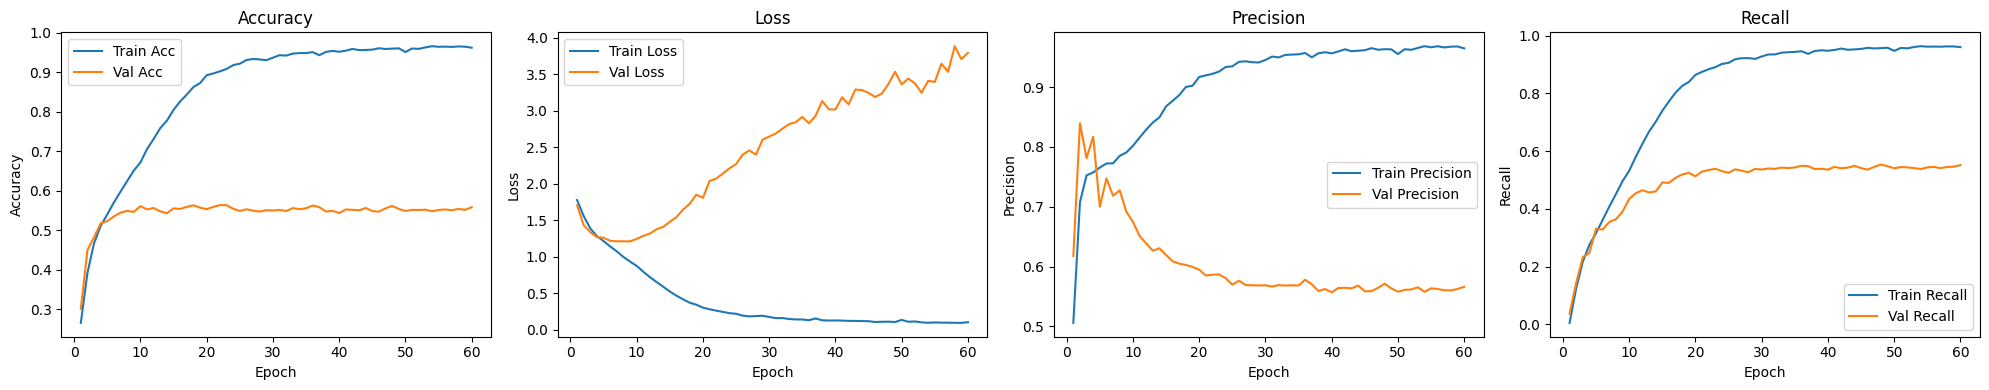

In [98]:
import matplotlib.pyplot as plt

def plot_curves(history_df):
    epochs = history_df['epoch']

    plt.figure(figsize=(20, 4))  # Wider figure for one-row layout

    # Accuracy
    plt.subplot(1, 4, 1)
    plt.plot(epochs, history_df['accuracy'], label='Train Acc')
    plt.plot(epochs, history_df['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 4, 2)
    plt.plot(epochs, history_df['loss'], label='Train Loss')
    plt.plot(epochs, history_df['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision
    plt.subplot(1, 4, 3)
    plt.plot(epochs, history_df['precision_4'], label='Train Precision')
    plt.plot(epochs, history_df['val_precision_4'], label='Val Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(1, 4, 4)
    plt.plot(epochs, history_df['recall_4'], label='Train Recall')
    plt.plot(epochs, history_df['val_recall_4'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run it
plot_curves(history_df)

In [112]:
# Predict using your trained model
predictions = model.predict(X_test)

# Convert prediction probabilities to class labels (e.g., 0–6 for 7 emotions)
predicted_classes = np.argmax(predictions, axis=1)

# Optional: decode label indices back to emotion names
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
decoded_predictions = [emotion_labels[i] for i in predicted_classes]

# Example output preview
print("Predicted class indices:", predicted_classes[:10])
print("Decoded predictions:", decoded_predictions[:10])

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
Predicted class indices: [3 0 5 3 0 2 0 0 4 0]
Decoded predictions: ['Happy', 'Angry', 'Surprise', 'Happy', 'Angry', 'Fear', 'Angry', 'Angry', 'Sad', 'Angry']


### Final Metrics

In [113]:
final_accuracy = history_df['accuracy'].iloc[-1]
final_precision = history_df['precision_4'].iloc[-1]
final_recall = history_df['recall_4'].iloc[-1]
final_val_loss = history_df['val_loss'].iloc[-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 96.19%
Final Precision       : 96.47%
Final Recall          : 96.02%
Final Validation Loss : 3.7936
Final F1 Score        : 0.962


### Confusion Matrix 

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


Text(0.5, 1.0, 'Facial Predictions Confusion Matrix')

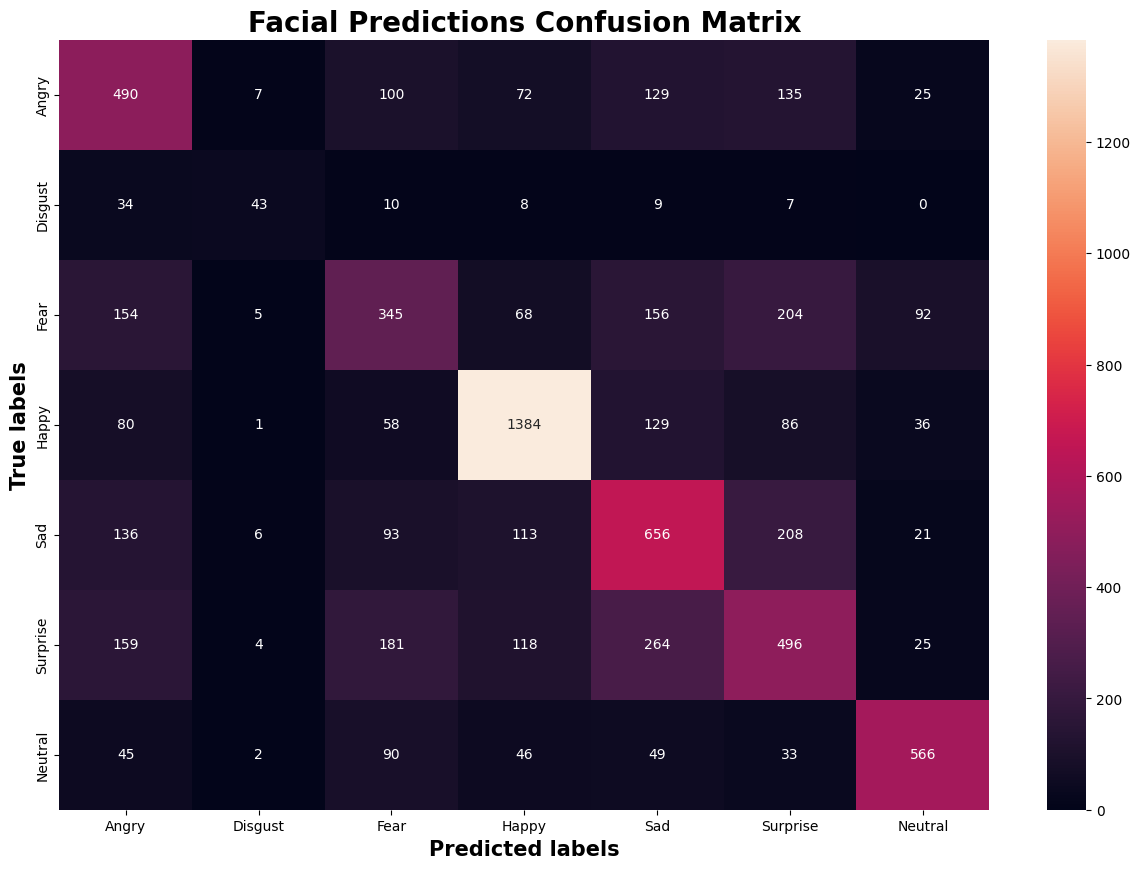

In [115]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

# Ensure you're predicting only on the test set
predictions = np.argmax(model.predict(X_test), axis=1)

# Ensure true labels match
true_labels = LabelEncoder().fit_transform(test_data['emotion'])

# Now generate the confusion matrix safely
cm = confusion_matrix(true_labels, predictions)

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('Facial Predictions Confusion Matrix', fontsize=20, fontweight='bold')

### Test your FER-2013 Predictions model
Select 10 random images and predict it

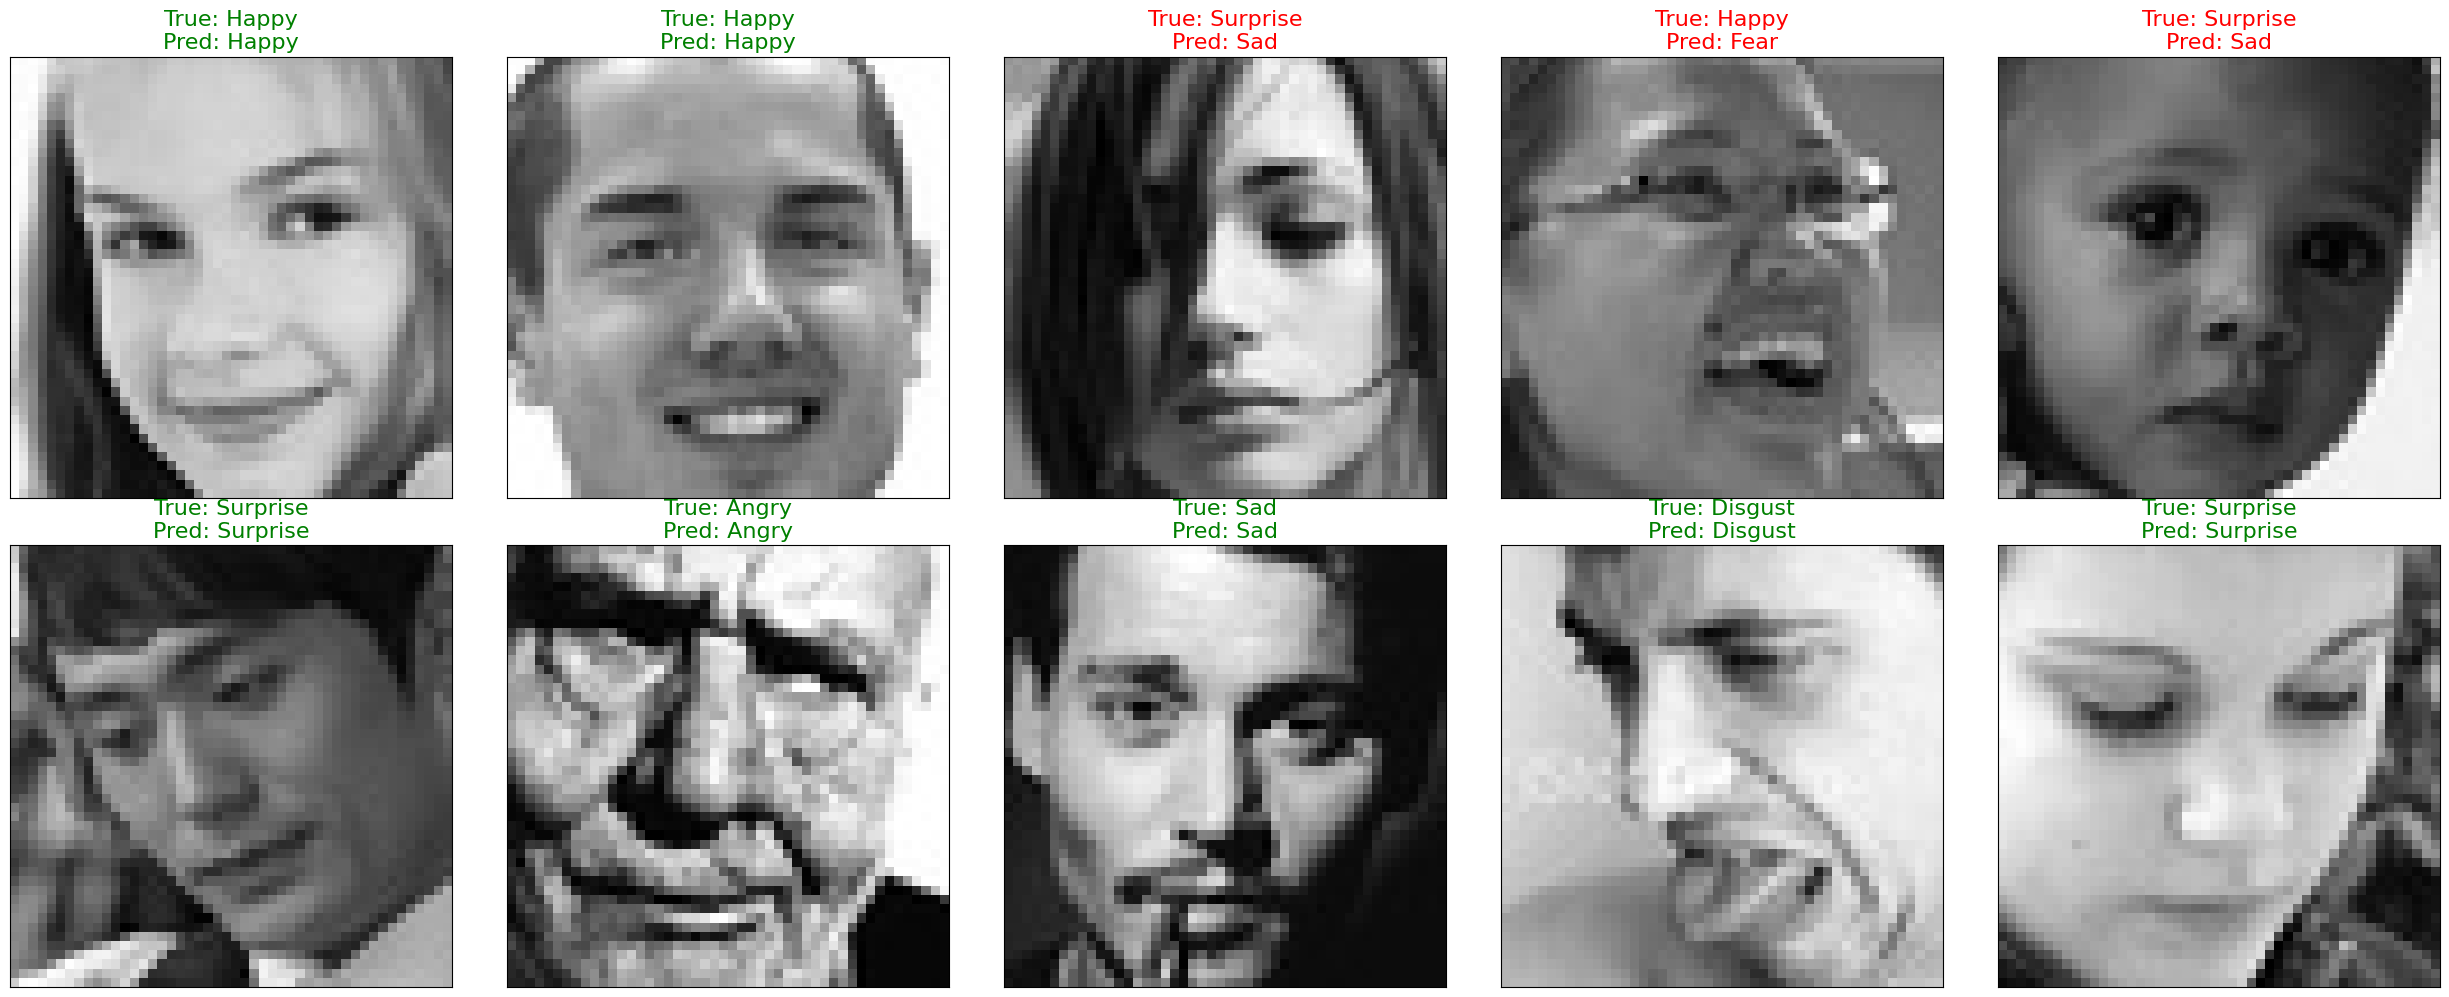

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder

# Emotion label mapping (adjust if needed)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Encode test labels to match model prediction format
le = LabelEncoder()
true_labels = le.fit_transform(test_data['emotion'])

# Generate predictions on test set
predicted_probs = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Pick 10 random indices to visualize
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = X_test[idx].reshape(48, 48)  # assuming grayscale input

    true_class = true_labels[idx]
    predicted_class = predicted_classes[idx]

    color = 'green' if true_class == predicted_class else 'red'
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {emotion_labels[true_class]}\nPred: {emotion_labels[predicted_class]}", 
                 color=color, fontsize=16)

plt.tight_layout()
plt.show()